In [1]:
import numpy as np
import pandas as pd

import statsmodels.formula.api as sfa
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings('ignore')

C:\Users\Gaurav Siwal\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Load and Data Description

In [2]:
# Lets read the dataset

data = pd.read_excel('Concrete_Data.xls')

In [3]:
# A breif description about data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              1030 non-null   float64
 1   blast_furnace_slag  1030 non-null   float64
 2   fly_ash             1030 non-null   float64
 3   water               1030 non-null   float64
 4   superplasticizer    1030 non-null   float64
 5   coarse_agg          1030 non-null   float64
 6   fine_agg            1030 non-null   float64
 7   age                 1030 non-null   int64  
 8   comp_strength       1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
blast_furnace_slag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
fly_ash,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
coarse_agg,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
fine_agg,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
comp_strength,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


## Univariate Analysis

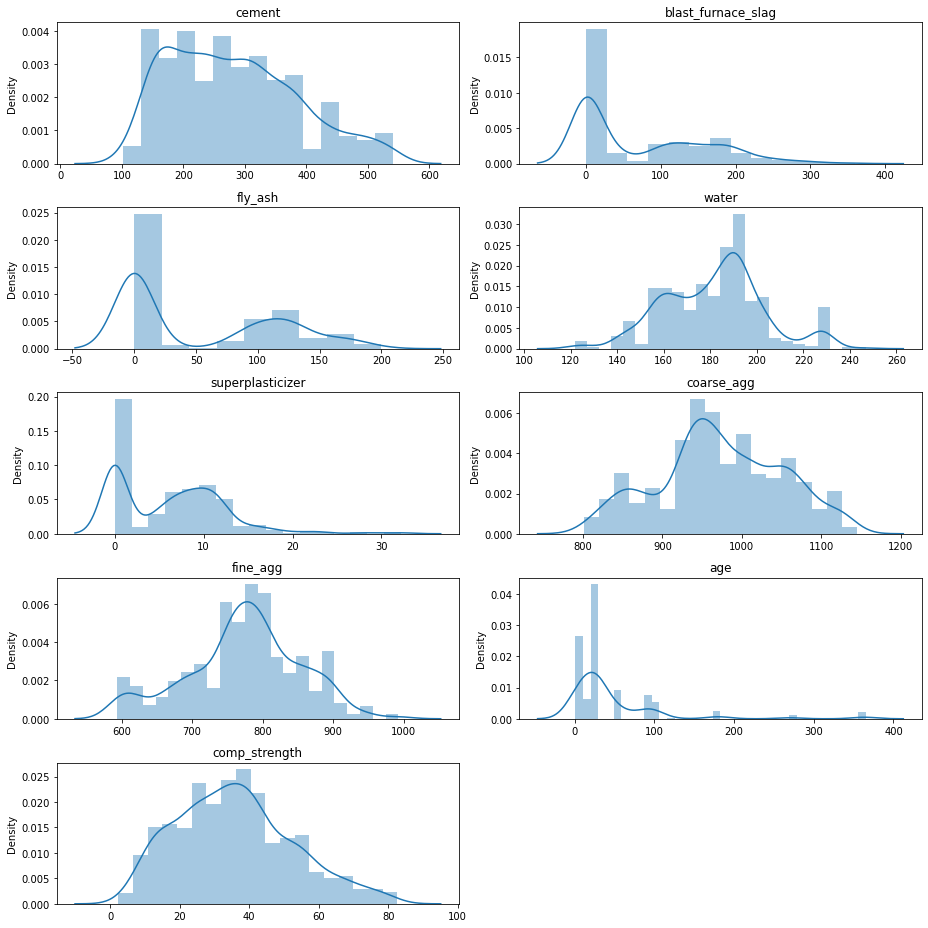

In [5]:
t = 1
plt.figure(figsize=(13,13))
for i in data.columns:
    plt.subplot(5,2,t)
    plt.title(i)
    sns.distplot(x=data[i],kde=True)
    t+=1
plt.tight_layout()
plt.show()

## Bivariate Analysis

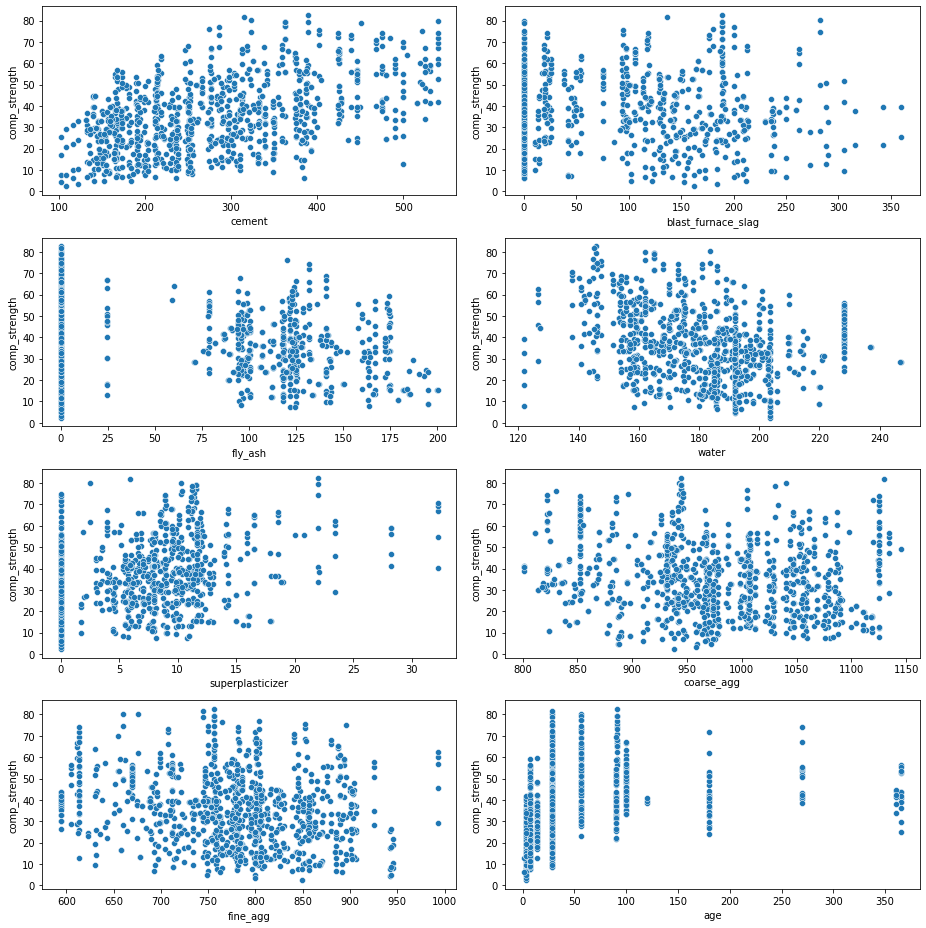

In [6]:
t = 1
plt.figure(figsize=(13,13))
for i in data.columns:
    if i!='comp_strength':
        plt.subplot(4,2,t)
        sns.scatterplot(x=data[i],y=data['comp_strength'])
        t+=1
plt.tight_layout()
plt.show()

<Axes: >

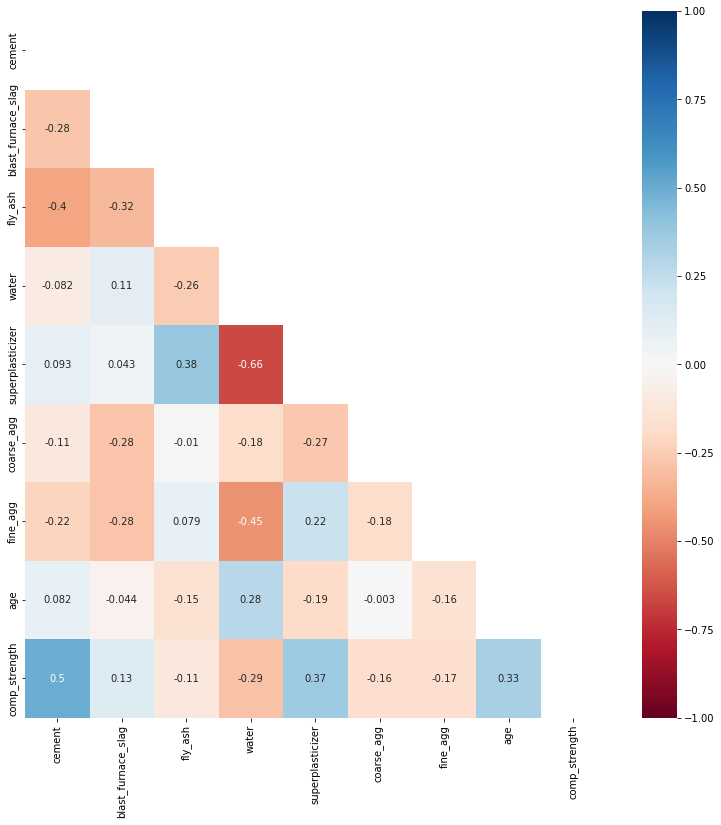

In [7]:
plt.figure(figsize=(13,13))
sns.heatmap(data.corr(),vmax=1,vmin=-1,cmap='RdBu',annot=True,mask=np.triu(data.corr()))

## Treating defects in dataset 

In [8]:
# Missing Values
data.isnull().sum()

cement                0
blast_furnace_slag    0
fly_ash               0
water                 0
superplasticizer      0
coarse_agg            0
fine_agg              0
age                   0
comp_strength         0
dtype: int64

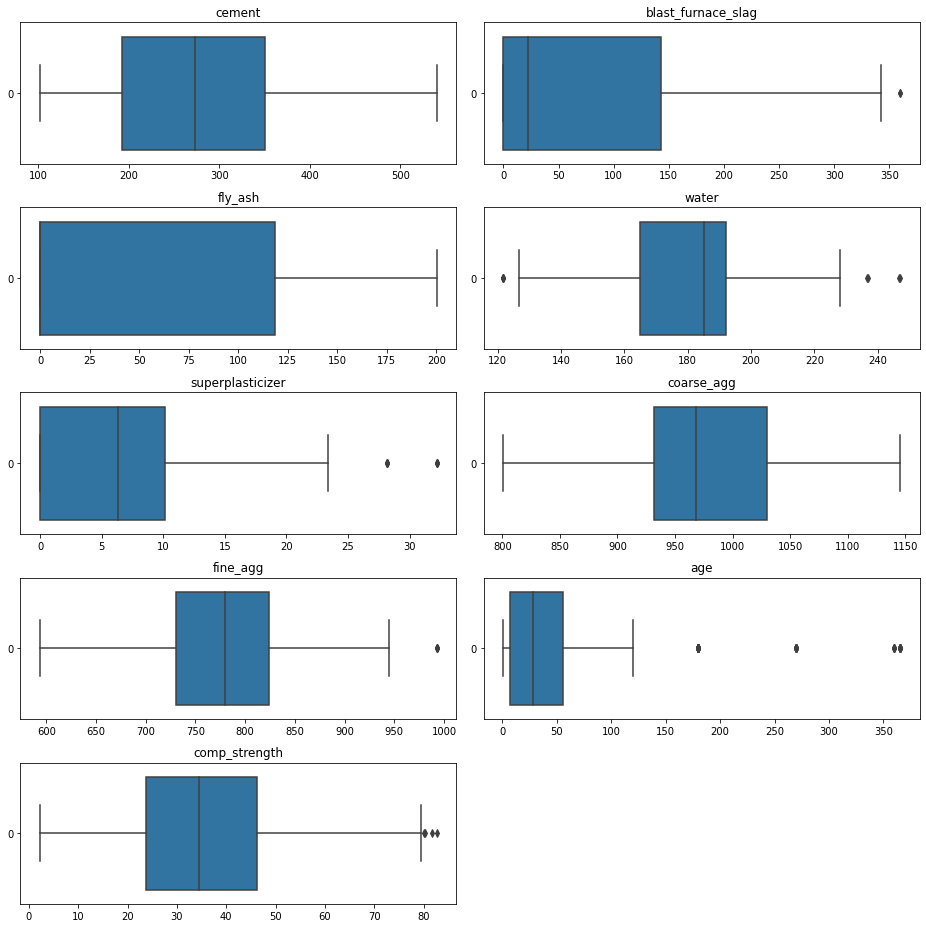

In [9]:
# Outliers
t = 1
plt.figure(figsize=(13,13))
for i in data.columns:
    plt.subplot(5,2,t)
    plt.title(i)
    sns.boxplot(data[i],orient='h')
    t+=1
plt.tight_layout()
plt.show()

In [10]:
# Removing Outliers
q3= data.quantile(0.75)
q1= data.quantile(0.25)

iqr= q3-q1

upper_limit= q3+1.5*iqr
lower_limit=q1-1.5*iqr

In [11]:
data= data.loc[~((data>upper_limit)|(data<lower_limit)).any(axis=1)]

In [12]:
data.shape

(941, 9)

## Building a base model

In [13]:
x = data.drop(columns=['comp_strength'])
y = data['comp_strength']
x_c = sma.add_constant(x)

model1 = sma.OLS(y,x_c).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          comp_strength   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     390.0
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          2.92e-291
Time:                        00:18:42   Log-Likelihood:                -3286.5
No. Observations:                 941   AIC:                             6591.
Df Residuals:                     932   BIC:                             6635.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 49.9873     22.409      2.231      0.026       6.010      93.964
cement                 0.1020      0.007     14.655      0.000       0.088       0.116
blast_furnace_slag     0.0755      0.008      8.982      0.000       0.059       0.092
fly_ash                0.0482      0.010      4.667      0.000       0.028       0.068
water                 -0.2496      0.035     -7.161      0.000      -0.318      -0.181
superplasticizer       0.2160      0.085      2.535      0.011       0.049       0.383
coarse_agg            -0.0103      0.008     -1.311      0.190      -0.026       0.005
fine_agg              -0.0103      0.009     -1.152      0.250      -0.028       0.007
age                    0.3127      0.009     34.065      0.000       0.295       0.331
==============================================================================
Omnibus:                        8.746   Durbin-Watson:                   1.295
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               10.120
Skew:                           0.147   Prob(JB):                      0.00635
Kurtosis:                       3.414   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# Check VIF for multicollienariry


vif_list = []

for i in range(x.shape[1]):
    vif_list.append(variance_inflation_factor(x.values,i))

pd.DataFrame({'Feature Names':x.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Names,VIF
3,water,95.869034
5,coarse_agg,84.887345
6,fine_agg,77.146873
0,cement,14.651196
4,superplasticizer,6.262356
2,fly_ash,4.850175
1,blast_furnace_slag,3.530360
7,age,2.305245


In [15]:
# In order deal with multicollinearty we need to remove coarse_agg, water, fine_agg and cement
# Lets check the model without "coarse_agg"

# We can see almost no drop in R2

sma.OLS(y,x_c.drop(columns=['coarse_agg'])).fit().rsquared

0.7695668016300983

In [16]:
# Lets check the model without "water"

# We can see negligible drop in R2

sma.OLS(y,x_c.drop(columns=['water'])).fit().rsquared

0.7573351580168639

In [17]:
# Lets check the model without "fine_agg"

# We can see almost no drop in R2

sma.OLS(y,x_c.drop(columns=['fine_agg'])).fit().rsquared

0.7696634100302264

In [18]:
# Lets check the model without "cement"

# We can see significant drop in R2

sma.OLS(y,x_c.drop(columns=['cement'])).fit().rsquared

0.7169901957955678

In [19]:
# Lets drop coarse_agg and check the VIF again
x.drop(columns=['coarse_agg'],inplace=True)

vif_list = []

for i in range(x.shape[1]):
    vif_list.append(variance_inflation_factor(x.values,i))

pd.DataFrame({'Feature Names':x.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Names,VIF
3,water,80.594235
5,fine_agg,57.419888
0,cement,14.211237
4,superplasticizer,6.262356
2,fly_ash,4.799446
1,blast_furnace_slag,3.529730
6,age,2.300589


In [20]:
# Lets check the model without "water"

# We can see significant drop in R2
x_c = sma.add_constant(x)
sma.OLS(y,x_c.drop(columns=['water'])).fit().rsquared

0.7418619808565375

In [21]:
# Lets check the model without "fine_agg"

# We can see almost no drop in R2

sma.OLS(y,x_c.drop(columns=['fine_agg'])).fit().rsquared

0.769565100592857

In [22]:
# Lets check the model without "cement"

# We can see significant drop in R2

sma.OLS(y,x_c.drop(columns=['cement'])).fit().rsquared

0.5985012781556749

In [23]:
# We can drop fine agg and see the VIF again

x.drop(columns=['fine_agg'],inplace=True)

vif_list = []

for i in range(x.shape[1]):
    vif_list.append(variance_inflation_factor(x.values,i))

pd.DataFrame({'Feature Names':x.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Names,VIF
3,water,21.266082
0,cement,13.857950
4,superplasticizer,4.630998
2,fly_ash,4.616193
1,blast_furnace_slag,3.171907
5,age,2.288071


In [24]:
# Lets check the model without "water"

# We can see significant drop in R2
x_c = sma.add_constant(x)
sma.OLS(y,x_c.drop(columns=['water'])).fit().rsquared

0.7379640182496451

In [25]:
# Lets check the model without "cement"

# We can see significant drop in R2

sma.OLS(y,x_c.drop(columns=['cement'])).fit().rsquared

0.5147895294521513

In [26]:
# So we have two options over here.
# Either we can drop the column water
# Or we can apply some domain knowlwdge and do Feature Engineering

## Feature Engineering

In [27]:
# Let create a new column by dividng cement/water, and call it "cem_water_ratio"

In [28]:
x['cem_water_ratio'] = x['cement']/x['water']

x.drop(columns=['water','cement'],inplace=True)

vif_list = []

for i in range(x.shape[1]):
    vif_list.append(variance_inflation_factor(x.values,i))

pd.DataFrame({'Feature Names':x.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Names,VIF
2,superplasticizer,3.933220
4,cem_water_ratio,3.117410
1,fly_ash,2.420682
3,age,2.128090
0,blast_furnace_slag,1.612342


## Final Model

In [29]:
# It seems much better. Also let us train the model again with these columns

In [30]:
x_c = sma.add_constant(x)

model2 = sma.OLS(y,x_c).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          comp_strength   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     601.8
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          2.94e-289
Time:                        00:18:43   Log-Likelihood:                -3300.7
No. Observations:                 941   AIC:                             6613.
Df Residuals:                     935   BIC:                             6643.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -16.4837      1.248    -13.209      0.000     -18.933     -14.035
blast_furnace_slag     0.0796      0.004     19.587      0.000       0.072       0.088
fly_ash                0.0601      0.007      9.052      0.000       0.047       0.073
superplasticizer       0.2879      0.070      4.102      0.000       0.150       0.426
age                    0.3122      0.009     33.639      0.000       0.294       0.330
cem_water_ratio       19.4152      0.597     32.540      0.000      18.244      20.586
==============================================================================
Omnibus:                        7.756   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                8.407
Skew:                           0.156   Prob(JB):                       0.0149
Kurtosis:                       3.342   Cond. No.                         619.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check for Assumptions

In [31]:
# Check for th other Assumptions
# Linerity
# Normality
# Homoscedasticty
# Autocorrelation

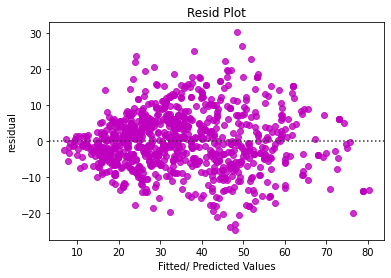

In [32]:
# Assumption of Linearity & Homoskedasticity
sns.residplot(x=model2.fittedvalues,y=model2.resid,color='m')
plt.xlabel('Fitted/ Predicted Values')
plt.ylabel('residual')
plt.title('Resid Plot')
plt.show()

In [33]:
# Rainbow test for linearity

# Ho: Varaibles are linear
# Ha: Variables are not linear
p_val = linear_rainbow(model2)[1]

if p_val <0.05:
    print('Reject Ho:')
else:
    print('Fail to reject Ho:')

Fail to reject Ho:


In [34]:
# Breusch Pagan test

# Ho: Data is Homoskedastic
# Ha: Data is Heteresckedastic

p_value = sma.stats.diagnostic.het_breuschpagan(model2.resid,model2.model.exog)[1]
print(p_value)
if p_value> 0.05:
    print('Fail to reject Ho:')
else:
    print('reject Ho:')

1.6514582654402573e-20
reject Ho:


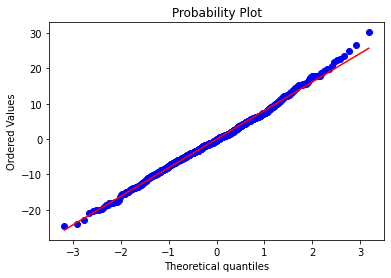

In [35]:
# Normality

stats.probplot(model2.resid,plot=plt)
plt.show()

In [36]:
# Shapiro Wilk test (N < 5000)

# Ho: The data is normal
# ha: The data is not normal

p_val = stats.shapiro(model2.resid)[1]
print(p_val)
if p_val> 0.05:
    print('Fail to reject Ho:')
else:
    print('reject Ho:')

0.02542245201766491
reject Ho:


## Interpretation from Coefficients

In [37]:
model2.params.sort_values()

const                -16.483677
fly_ash                0.060072
blast_furnace_slag     0.079638
superplasticizer       0.287903
age                    0.312238
cem_water_ratio       19.415154
dtype: float64

<Axes: >

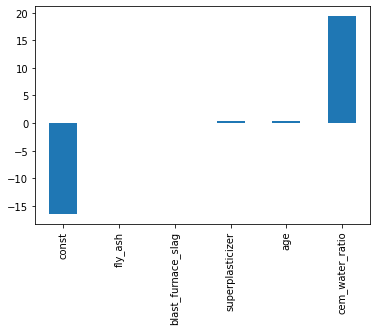

In [38]:
model2.params.sort_values().plot(kind='bar')

## Model Validation

In [39]:
# Lets do a train test split to validate the model

In [40]:
def validation(test,pred):
    print('R2:',r2_score(test,pred))
    print('MSE:',mean_squared_error(test,pred))
    print('RMSE:',np.sqrt(mean_squared_error(test,pred)))
    print('MAE:',mean_absolute_error(test,pred))
    print('MAPE:',mean_absolute_percentage_error(test,pred))

In [41]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.75,random_state=2)

In [42]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(705, 5) (705,) (236, 5) (236,)


In [43]:
final_model = LinearRegression() # Linear regression from sklearn

In [44]:
final_model.fit(x_train,y_train)

LinearRegression()

In [45]:
train_pred = final_model.predict(x_train)
test_pred = final_model.predict(x_test)

In [46]:
# Training Scores
validation(y_train,train_pred)

R2: 0.7618236920810053
MSE: 65.45459958029707
RMSE: 8.09040169461919
MAE: 6.250862878969333
MAPE: 0.22541576628337173


In [47]:
# Test Scores
validation(y_test,test_pred)

R2: 0.7629410398350154
MSE: 65.33127418963373
RMSE: 8.082776391168677
MAE: 6.419657272464778
MAPE: 0.23981401816939144


In [48]:
# It Seems to be a good fit model

## Deployment

In [49]:
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("Model saved as 'lr_model.pkl'")

Model saved as 'lr_model.pkl'


In [50]:
x_train.columns

Index(['blast_furnace_slag', 'fly_ash', 'superplasticizer', 'age',
       'cem_water_ratio'],
      dtype='object')